<a href="https://colab.research.google.com/github/abotg/Market-Maker-Simulator/blob/main/optiver_market_making_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

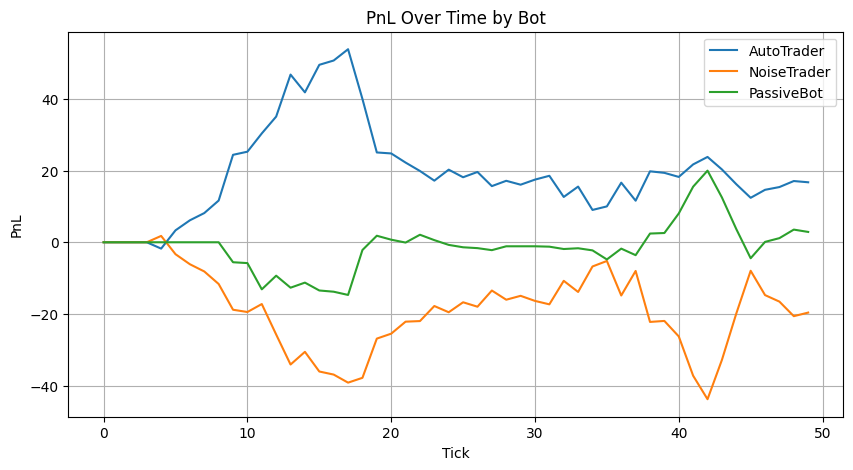

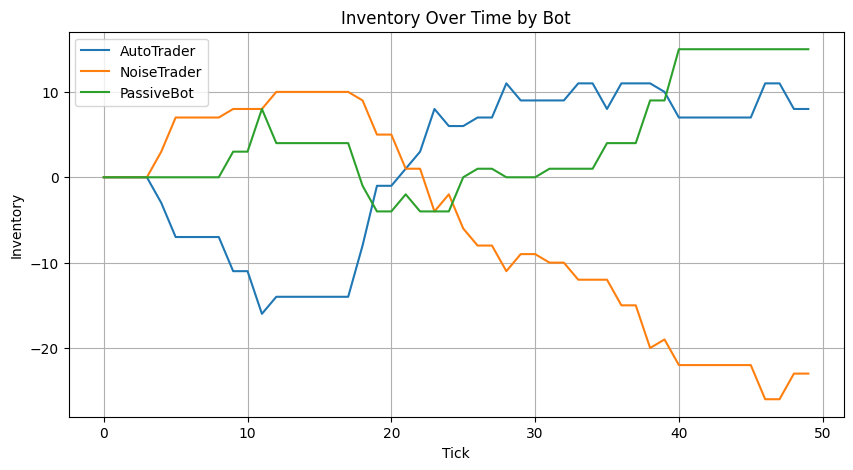

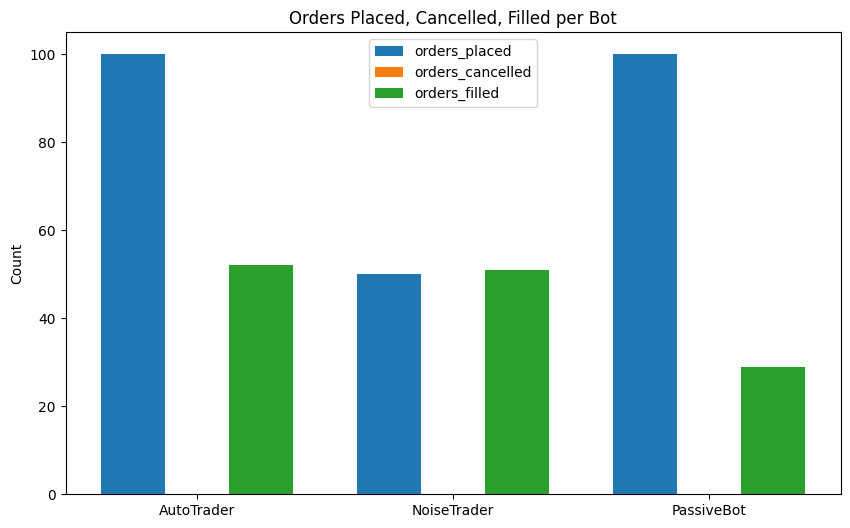

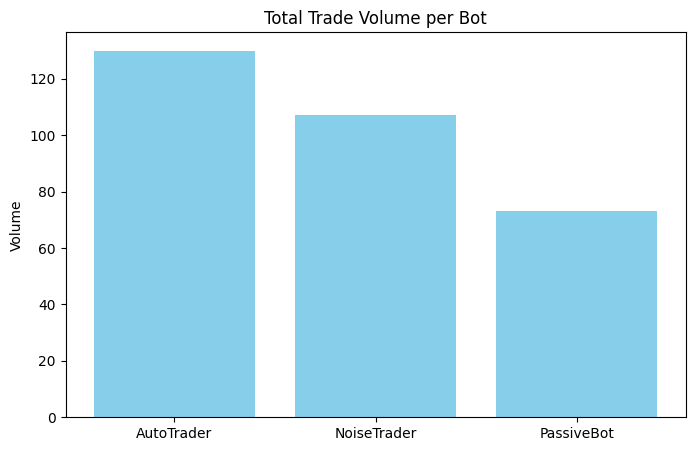

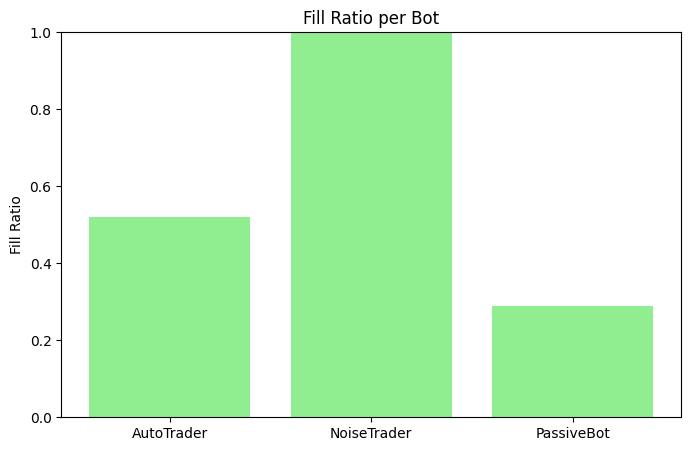

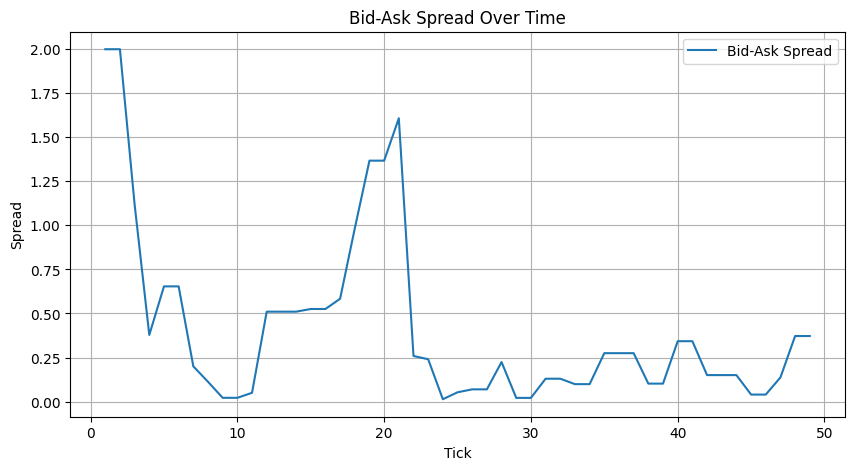

In [ ]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# === Order and Exchange ===

class Order:
    def __init__(self, order_id, owner, side, price, qty, timestamp):
        self.order_id = order_id
        self.owner = owner
        self.side = side
        self.price = price
        self.qty = qty
        self.timestamp = timestamp

class OrderBook:
    def __init__(self):
        self.buy_orders = []
        self.sell_orders = []
        self.order_id_counter = 1
        self.timestamp_counter = 0
        self.active_orders = {}

    def place_order(self, owner, side, price, qty):
        self.timestamp_counter += 1
        order = Order(self.order_id_counter, owner, side, price, qty, self.timestamp_counter)
        self.order_id_counter += 1
        self.active_orders[order.order_id] = order
        if side == 'BUY':
            return self.match_buy(order)
        else:
            return self.match_sell(order)

    def cancel_order(self, order_id):
        if order_id in self.active_orders:
            order = self.active_orders[order_id]
            order.qty = 0
            del self.active_orders[order_id]
            return order.owner
        return None

    def _clean_heap(self, heap):
        while heap:
            price, ts, order = heap[0]
            if order.qty <= 0 or order.order_id not in self.active_orders:
                heapq.heappop(heap)
            else:
                break

    def match_buy(self, buy_order):
        trades = []
        while self.sell_orders and buy_order.qty > 0:
            self._clean_heap(self.sell_orders)
            if not self.sell_orders:
                break
            best_price, best_time, best_sell = self.sell_orders[0]
            if best_price > buy_order.price:
                break
            trade_qty = min(buy_order.qty, best_sell.qty)
            trades.append({
                "buyer": buy_order.owner,
                "seller": best_sell.owner,
                "price": best_sell.price,
                "qty": trade_qty
            })
            buy_order.qty -= trade_qty
            best_sell.qty -= trade_qty
            if best_sell.qty == 0:
                self.cancel_order(best_sell.order_id)
                heapq.heappop(self.sell_orders)
        if buy_order.qty > 0:
            heapq.heappush(self.buy_orders, (-buy_order.price, buy_order.timestamp, buy_order))
        return trades

    def match_sell(self, sell_order):
        trades = []
        while self.buy_orders and sell_order.qty > 0:
            self._clean_heap(self.buy_orders)
            if not self.buy_orders:
                break
            _, best_time, best_buy = self.buy_orders[0]
            if best_buy.price < sell_order.price:
                break
            trade_qty = min(sell_order.qty, best_buy.qty)
            trades.append({
                "buyer": best_buy.owner,
                "seller": sell_order.owner,
                "price": best_buy.price,
                "qty": trade_qty
            })
            sell_order.qty -= trade_qty
            best_buy.qty -= trade_qty
            if best_buy.qty == 0:
                self.cancel_order(best_buy.order_id)
                heapq.heappop(self.buy_orders)
        if sell_order.qty > 0:
            heapq.heappush(self.sell_orders, (sell_order.price, sell_order.timestamp, sell_order))
        return trades

    def get_depth(self, depth=5):
        bids, asks = defaultdict(int), defaultdict(int)
        for _, ts, order in self.buy_orders:
            if order.qty > 0 and order.order_id in self.active_orders:
                bids[order.price] += order.qty
        for price, ts, order in self.sell_orders:
            if order.qty > 0 and order.order_id in self.active_orders:
                asks[order.price] += order.qty
        top_bids = sorted(bids.items(), key=lambda x: -x[0])[:depth]
        top_asks = sorted(asks.items(), key=lambda x: x[0])[:depth]
        return top_bids, top_asks

# === Traders ===

class AutoTrader:
    def __init__(self, exchange, name="AutoTrader", spread=2, quantity=5, inventory_skew_factor=0.05):
        self.exchange = exchange
        self.name = name
        self.spread = spread
        self.quantity = quantity
        self.inventory_skew_factor = inventory_skew_factor
        self.live_orders = []

    def quote(self, fair_price, bots, current_tick, delayed_orders):
        for oid in self.live_orders:
            owner = self.exchange.cancel_order(oid)
            if owner:
                bots[owner]["orders_cancelled"] += 1
        self.live_orders = []

        latency = random.randint(0, 3)
        inventory = bots[self.name]["inventory"]
        skew = -inventory * self.inventory_skew_factor

        bid_price = fair_price - self.spread / 2 + skew
        ask_price = fair_price + self.spread / 2 + skew

        delayed_orders.append((current_tick + latency, self.name, "BUY", bid_price, self.quantity))
        delayed_orders.append((current_tick + latency, self.name, "SELL", ask_price, self.quantity))

        bots[self.name]["orders_placed"] += 2

class NoiseTrader:
    def __init__(self, exchange, name="NoiseTrader", quantity_range=(1, 5)):
        self.exchange = exchange
        self.name = name
        self.quantity_range = quantity_range

    def trade(self, fair_price, bots, current_tick, delayed_orders):
        latency = random.randint(0, 3)
        side = random.choice(["BUY", "SELL"])
        qty = random.randint(*self.quantity_range)
        price = fair_price + random.uniform(0.5, 1.0) if side == "BUY" else fair_price - random.uniform(0.5, 1.0)

        delayed_orders.append((current_tick + latency, self.name, side, price, qty))
        bots[self.name]["orders_placed"] += 1

class PassiveBot:
    def __init__(self, exchange, name="PassiveBot", spread_range=(1, 3), quantity_range=(1, 5)):
        self.exchange = exchange
        self.name = name
        self.spread_range = spread_range
        self.quantity_range = quantity_range
        self.live_orders = []

    def quote(self, fair_price, bots, current_tick, delayed_orders):
        for oid in self.live_orders:
            owner = self.exchange.cancel_order(oid)
            if owner:
                bots[owner]["orders_cancelled"] += 1
        self.live_orders = []

        latency = random.randint(0, 3)
        spread = random.uniform(*self.spread_range)
        qty = random.randint(*self.quantity_range)
        bid_price = fair_price - spread / 2
        ask_price = fair_price + spread / 2

        delayed_orders.append((current_tick + latency, self.name, "BUY", bid_price, qty))
        delayed_orders.append((current_tick + latency, self.name, "SELL", ask_price, qty))

        bots[self.name]["orders_placed"] += 2

# === Synthetic Data ===

def generate_synthetic_data(n_ticks=50, seed=42):
    np.random.seed(seed)
    drift = 0.0002
    volatility = 0.01
    prices = {'StockA': [100], 'StockB': [95], 'StockC': [105]}
    for _ in range(n_ticks - 1):
        for stock in prices:
            last_price = prices[stock][-1]
            ret = np.random.normal(drift, volatility)
            new_price = last_price * np.exp(ret)
            prices[stock].append(new_price)
    df = pd.DataFrame(prices)
    df['ETF_Fair'] = 0.4 * df['StockA'] + 0.3 * df['StockB'] + 0.3 * df['StockC']
    df['Tick'] = df.index
    return df[['Tick', 'StockA', 'StockB', 'StockC', 'ETF_Fair']]

# === Simulation ===

df = generate_synthetic_data()
exchange = OrderBook()

auto_trader = AutoTrader(exchange)
noise_trader = NoiseTrader(exchange)
passive_bot = PassiveBot(exchange)

bots = {
    "AutoTrader": {"inventory": 0, "realized_pnl": 0, "pnl_history": [], "inventory_history": [],
                   "orders_placed": 0, "orders_cancelled": 0, "orders_filled": 0, "volume_traded": 0},
    "NoiseTrader": {"inventory": 0, "realized_pnl": 0, "pnl_history": [], "inventory_history": [],
                    "orders_placed": 0, "orders_cancelled": 0, "orders_filled": 0, "volume_traded": 0},
    "PassiveBot": {"inventory": 0, "realized_pnl": 0, "pnl_history": [], "inventory_history": [],
                   "orders_placed": 0, "orders_cancelled": 0, "orders_filled": 0, "volume_traded": 0}
}

spread_history = []
delayed_orders = []

for tick in df.itertuples():
    fair_price = tick.ETF_Fair
    current_tick = tick.Tick
    trades = []

    # Process delayed orders for this tick
    to_execute = [order for order in delayed_orders if order[0] == current_tick]
    delayed_orders = [order for order in delayed_orders if order[0] > current_tick]

    for release_tick, bot_name, side, price, qty in to_execute:
        trades += exchange.place_order(bot_name, side, price, qty)

    auto_trader.quote(fair_price, bots, current_tick, delayed_orders)
    noise_trader.trade(fair_price, bots, current_tick, delayed_orders)
    passive_bot.quote(fair_price, bots, current_tick, delayed_orders)

    top_bids, top_asks = exchange.get_depth(depth=1)
    if top_bids and top_asks:
        best_bid = top_bids[0][0]
        best_ask = top_asks[0][0]
        spread_history.append((current_tick, best_bid, best_ask))
    else:
        spread_history.append((current_tick, np.nan, np.nan))

    for trade in trades:
        price = trade["price"]
        qty = trade["qty"]
        buyer = trade["buyer"]
        seller = trade["seller"]

        bots[buyer]["inventory"] += qty
        bots[buyer]["realized_pnl"] -= price * qty
        bots[buyer]["orders_filled"] += 1
        bots[buyer]["volume_traded"] += qty

        bots[seller]["inventory"] -= qty
        bots[seller]["realized_pnl"] += price * qty
        bots[seller]["orders_filled"] += 1
        bots[seller]["volume_traded"] += qty

    for bot_name, stats in bots.items():
        total_pnl = stats["realized_pnl"] + stats["inventory"] * fair_price
        stats["pnl_history"].append(total_pnl)
        stats["inventory_history"].append(stats["inventory"])

# Fill Ratios
for bot_name, stats in bots.items():
    if stats["orders_placed"] > 0:
        stats["fill_ratio"] = stats["orders_filled"] / stats["orders_placed"]
    else:
        stats["fill_ratio"] = 0.0

# === Plotting ===

# PnL
plt.figure(figsize=(10, 5))
for bot_name, stats in bots.items():
    plt.plot(df["Tick"], stats["pnl_history"], label=bot_name)
plt.xlabel("Tick")
plt.ylabel("PnL")
plt.title("PnL Over Time by Bot")
plt.legend()
plt.grid(True)
plt.show()

# Inventory
plt.figure(figsize=(10, 5))
for bot_name, stats in bots.items():
    plt.plot(df["Tick"], stats["inventory_history"], label=bot_name)
plt.xlabel("Tick")
plt.ylabel("Inventory")
plt.title("Inventory Over Time by Bot")
plt.legend()
plt.grid(True)
plt.show()

# Orders
plt.figure(figsize=(10, 6))
metrics = ["orders_placed", "orders_cancelled", "orders_filled"]
x = range(len(bots))
width = 0.25
for i, m in enumerate(metrics):
    plt.bar([p + i*width for p in x],
            [bots[b][m] for b in bots],
            width=width,
            label=m)
plt.xticks([p + width for p in x], bots.keys())
plt.ylabel("Count")
plt.title("Orders Placed, Cancelled, Filled per Bot")
plt.legend()
plt.show()

# Volume
plt.figure(figsize=(8, 5))
plt.bar(bots.keys(), [bots[b]["volume_traded"] for b in bots], color="skyblue")
plt.ylabel("Volume")
plt.title("Total Trade Volume per Bot")
plt.show()

# Fill Ratio
plt.figure(figsize=(8, 5))
plt.bar(bots.keys(), [bots[b]["fill_ratio"] for b in bots], color="lightgreen")
plt.ylabel("Fill Ratio")
plt.title("Fill Ratio per Bot")
plt.ylim(0, 1)
plt.show()

# Spread Plot
spread_df = pd.DataFrame(spread_history, columns=["Tick", "Best_Bid", "Best_Ask"])
spread_df["Mid"] = (spread_df["Best_Bid"] + spread_df["Best_Ask"]) / 2
spread_df["Spread"] = spread_df["Best_Ask"] - spread_df["Best_Bid"]

plt.figure(figsize=(10, 5))
plt.plot(spread_df["Tick"], spread_df["Spread"], label="Bid-Ask Spread")
plt.xlabel("Tick")
plt.ylabel("Spread")
plt.title("Bid-Ask Spread Over Time")
plt.grid(True)
plt.legend()
plt.show()
